# The Annotated Encoder-Decoder with Attention

Recently, Alexander Rush wrote a blog post called [The Annotated Transformer](http://nlp.seas.harvard.edu/2018/04/03/attention.html), describing the Transformer model from the paper [Attention is All You Need](https://arxiv.org/abs/1706.03762). This post can be seen as a **prequel** to that: *we will implement an Encoder-Decoder with Attention* using (Gated) Recurrent Neural Networks, very closely following the original attention-based neural machine translation paper ["Neural Machine Translation by Jointly Learning to Align and Translate"](https://arxiv.org/abs/1409.0473) of Bahdanau et al. (2015).

The idea is that going through both blog posts will make you familiar with two very influential sequence-to-sequence architectures. If you have any comments or suggestions, please let me know on Twitter [@joostbastings](https://twitter.com/joostbastings) or e-mail me at *firstname dot lastname @ gmail dot com*.

# Model Architecture

We will model the probability $p(Y\mid X)$ of a target sequence $Y=(y_1, \dots, y_{N})$ given a source sequence $X=(x_1, \dots, x_M)$ directly with a neural network: an Encoder-Decoder.

<img src="https://github.com/bastings/annotated_encoder_decoder/blob/master/images/bahdanau.png?raw=1" width="636">

#### Encoder

The encoder reads in the source sentence (*at the bottom of the figure*) and produces a sequence of hidden states $\mathbf{h}_1, \dots, \mathbf{h}_M$, one for each source word. These states should capture the meaning of a word in its context of the given sentence.

We will use a bi-directional recurrent neural network (Bi-RNN) as the encoder; a Bi-GRU in particular.

First of all we **embed** the source words.
We simply look up the **word embedding** for each word in a (randomly initialized) lookup table.
We will denote the word embedding for word $i$ in a given sentence with $\mathbf{x}_i$.
By embedding words, our model may exploit the fact that certain words (e.g. *cat* and *dog*) are semantically similar, and can be processed in a similar way.

Now, how do we get hidden states $\mathbf{h}_1, \dots, \mathbf{h}_M$? A forward GRU reads the source sentence left-to-right, while a backward GRU reads it right-to-left.
Each of them follows a simple recursive formula: \
$$\mathbf{h}_j = \text{GRU}( \mathbf{x}_j , \mathbf{h}_{j - 1} )$$
i.e. we obtain the next state from the previous state and the current input word embedding.

The hidden state of the forward GRU at time step $j$ will know what words **precede** the word at that time step, but it doesn't know what words will follow. In contrast, the backward GRU will only know what words **follow** the word at time step $j$. By **concatenating** those two hidden states (*shown in blue in the figure*), we get $\mathbf{h}_j$, which captures word $j$ in its full sentence context.


#### Decoder

The decoder (*at the top of the figure*) is a GRU with hidden state $\mathbf{s_i}$. It follows a similar formula to the encoder, but takes one extra input $\mathbf{c}_{i}$ (*shown in yellow*).

$$\mathbf{s}_{i} = f( \mathbf{s}_{i - 1}, \mathbf{y}_{i - 1}, \mathbf{c}_i )$$

Here, $\mathbf{y}_{i - 1}$ is the previously generated target word (*not shown*).

At each time step, an **attention mechanism** dynamically selects that part of the source sentence that is most relevant for predicting the current target word. It does so by comparing the last decoder state with each source hidden state. The result is a context vector $\mathbf{c_i}$ (*shown in yellow*).
Later the attention mechanism is explained in more detail.

After computing the decoder state $\mathbf{s}_i$, a non-linear function $g$ (which applies a [softmax](https://en.wikipedia.org/wiki/Softmax_function)) gives us the probability of the target word $y_i$ for this time step:

$$ p(y_i \mid y_{<i}, x_1^M) = g(\mathbf{s}_i, \mathbf{c}_i, \mathbf{y}_{i - 1})$$

Because $g$ applies a softmax, it provides a vector the size of the output vocabulary that sums to 1.0: it is a distribution over all target words. During test time, we would select the word with the highest probability for our translation.

Now, for optimization, a [cross-entropy loss](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy) is used to maximize the probability of selecting the correct word at this time step. All parameters (including word embeddings) are then updated to maximize this probability.



# Prelims

This tutorial requires **PyTorch >= 0.4.1** and was tested with **Python 3.6**.

Make sure you have those versions, and install the packages below if you don't have them yet.

In [ ]:
#!pip install torch numpy matplotlib sacrebleu

In [12]:

%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from IPython.core.debugger import set_trace

# we will use CUDA if it is available
USE_CUDA = False # torch.cuda.is_available()
#DEVICE=torch.device('cuda:0') # or set to 'cpu'
#print("CUDA:", USE_CUDA)
#print(DEVICE)

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
#torch.cuda.manual_seed(seed)

# Let's start coding!

## Model class

Our base model class `EncoderDecoder` is very similar to the one in *The Annotated Transformer*.

One difference is that our encoder also returns its final states (`encoder_final` below), which is used to initialize the decoder RNN. We also provide the sequence lengths as the RNNs require those.

In [14]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many
    other models.
    
    Arguments:
        :param: encoder
        :param: decoder
        :param: sourceEmbedding: the word embedding of the source sentence
        :param: targetEmbedding
        :param: generator: 
        
        
    Returns: 
    """
    def __init__(self, encoder, decoder, sourceEmbedding, targetEmbedding, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.sourceEmbedding = sourceEmbedding
        self.targetEmbedding = targetEmbedding
        self.generator = generator

    def forward(self, source, target, sourceMask, targetMask, sourceLengths, targetLengths):
        """Take in and process masked src and target sequences."""
        encoderHidden, encoderFinal = self.encode(source, sourceMask, sourceLengths)
        return self.decode(encoderHidden, encoderFinal, sourceMask, target, targetMask)

    def encode(self, source, sourceMask, sourceLengths):
        return self.encoder(self.sourceEmbedding(source), sourceMask, sourceLengths)

    def decode(self, encoderHidden, encoderFinal, sourceMask, target, targetMask,
               decoderHidden=None):
        return self.decoder(self.targetEmbedding(target), encoderHidden, encoderFinal,
                            sourceMask, targetMask, hidden=decoderHidden)

To keep things easy we also keep the `Generator` class the same.
It simply projects the pre-output layer ($x$ in the `forward` function below) to obtain the output layer, so that the final dimension is the target vocabulary size.

In [15]:
class Generator(nn.Module):
    """
    Define standard linear + softmax generation step.
    
    Job of Generator: to project the pre-output layer  to 
    obtain the output layer, so the final dimension is the target vocabulary size. 
    """
    def __init__(self, hiddenSize, vocabSize):
        super(Generator, self).__init__()
        self.proj = nn.Linear(hiddenSize, vocabSize, bias=False)


    def forward(self, preOutputLayer):
        """
        
        :param preOutputLayer: 
        :return: 
        """
        return F.log_softmax(self.proj(preOutputLayer), dim=-1)

## Encoder

Our encoder is a bi-directional GRU.

Because we want to process multiple sentences at the same time for speed reasons (it is more effcient on GPU), we need to support **mini-batches**. Sentences in a mini-batch may have different lengths, which means that the RNN needs to unroll further for certain sentences while it might already have finished for others:

```
Example: mini-batch with 3 source sentences of different lengths (7, 5, and 3).
End-of-sequence is marked with a "3" here, and padding positions with "1".

# +---------------+
| 4 5 9 8 7 8 3 |
# +---------------+
| 5 4 8 7 3 1 1 |
# +---------------+
| 5 8 3 1 1 1 1 |
# +---------------+
```
You can see that, when computing hidden states for this mini-batch, for sentence #2 and #3 we will need to stop updating the hidden state after we have encountered "3". We don't want to incorporate the padding values (1s).

Luckily, PyTorch has convenient helper functions called `pack_padded_sequence` and `pad_packed_sequence`.
These functions take care of masking and padding, so that the resulting word representations are simply zeros after a sentence stops.

The code below reads in a source sentence (a sequence of word embeddings) and produces the hidden states.
It also returns a final vector, a summary of the complete sentence, by concatenating the first and the last hidden states (they have both seen the whole sentence, each in a different direction). We will use the final vector to initialize the decoder.

In [16]:
class Encoder(nn.Module):
    """Encodes a sequence of word embeddings
    
    The Encoder is a bidirectional GRU. 
    
    Similar to previous one in Annotated Transformer but here Encoder also returns its
    final states (encoderFinalStates) to initialize the decoder RNN. 
    
    Arguments: 
        :param: inputSize:
        :param: hiddenSize: 
        :param:numLayers: 
        :param: dropout 
    Returns: 
        sequence of hidden states h_1, ..., h_M after reading in a source sentence (a
        sequence of word embeddings).
    """
    def __init__(self, inputSize, hiddenSize, numLayers=1, dropout=0.):
        super(Encoder, self).__init__()
        self.num_layers = numLayers
        self.rnn = nn.GRU(inputSize, hiddenSize, numLayers,
                          batch_first=True, bidirectional=True, dropout=dropout)

    def forward(self, wordEmbeddings, mask, lengths):
        """
        Applies a bidirectional GRU to sequence of embeddings x.
        The input mini-batch x needs to be sorted by length.
        x should have dimensions [batch, time, dim].
        
        Arguments: 
            :param: wordEmbeddings = sequence of word embeddings, (was renamed from x, 
            where x_i is the word embedding for word (i). 
            :param: mask 
            :param: lengths
            TODO: are these the sequence lengths?
            https://hyp.is/SBrYxARqEeqYQVugq1n0_w/bastings.github.io/annotated_encoder_decoder/
            
        Returns: 
            the concatenated forward-backward hidden states
        """
        
        # note: pack_padded_sequence etc take care of masking and padding so the
        # resulting word representations are zero after a sentence stops. 
        packed = pack_padded_sequence(wordEmbeddings, lengths, batch_first=True)
        
        # TODO: is this where we "obtain the next state from previous state?"
        # https://hyp.is/scdj5gJiEeqtYhtdO0gpEw/bastings.github.io/annotated_encoder_decoder/
        output, final = self.rnn(packed)
        output, _ = pad_packed_sequence(output, batch_first=True)

        # Building the final vector, which is a summary of the complete sentence, by
        # concatenating the first and last hidden states, which have seen the whole
        # sentence, each in either forward or backward direction. 
        forwardFinal = final[0:final.size(0):2] # forward-encoded word embeddings
        backwardFinal = final[1:final.size(0):2] # backward-encoded word embeddings


        # Need to manually concatenate the final states for both directions
        # Final vector will be used to initialize the decoder. 
        final = torch.cat([forwardFinal, backwardFinal], dim=2)  # [num_layers, batch, 2*dim]

        return output, final

### Decoder

The decoder is a conditional GRU. Rather than starting with an empty state like the encoder, its initial hidden state results from a projection of the encoder final vector.

#### Training
In `forward` you can find a for-loop that computes the decoder hidden states one time step at a time.
Note that, during training, we know exactly what the target words should be! (They are in `trg_embed`.) This means that we are not even checking here what the prediction is! We simply feed the correct previous target word embedding to the GRU at each time step. This is called teacher forcing.

The `forward` function returns all decoder hidden states and pre-output vectors. Elsewhere these are used to compute the loss, after which the parameters are updated.

#### Prediction
For prediction time, for forward function is only used for a single time step. After predicting a word from the returned pre-output vector, we can call it again, supplying it the word embedding of the previously predicted word and the last state.

In [29]:
class Decoder(nn.Module):
    """A conditional RNN decoder with attention.
    
    Arguments: 
        :param: attention = the attention mechanism that selects relevant parts of source
        sentence using hidden state.
        :param: embeddingSize = 
        :param: hiddenSize = 
        :param:  numLayers = number of decoder layers
        :param: dropout =  
        
    """

    def __init__(self, embeddingSize, hiddenSize, attention, numLayers=1, dropout=0.5,
                 bridge=True):
        super(Decoder, self).__init__()

        self.hiddenSize = hiddenSize
        self.numLayers = numLayers
        self.attention = attention
        self.dropout = dropout

        self.rnn = nn.GRU(embeddingSize + 2 * hiddenSize, hiddenSize, numLayers,
                          batch_first=True, dropout=dropout)

        # to initialize from the final encoder state
        self.bridge = nn.Linear(2 * hiddenSize, hiddenSize, bias=True) if bridge else None

        self.dropout = nn.Dropout(p=dropout)
        self.preOutputLayer = nn.Linear(hiddenSize + 2 * hiddenSize + embeddingSize,
                                        hiddenSize, bias=False)


    # TODO: which variable contains the hidden states? h_1, ... h_M
    # https://hyp.is/C4gISASBEeqEyD--m5AQUw/bastings.github.io/annotated_encoder_decoder/
    def forwardStep(self, prevEmbedding, encoderHidden, sourceMask, projKey, hidden):
        """
        Perform a single decoder step (1 word). 
        Does MLP with tanh-activation taking current decoder state s_i and each encoder 
        state h_j and projects these to a single scalar value called attention energy e_ij. 
        
        :param prevEmbedding: 
        :param encoderHidden: 
        :param sourceMask: 
        :param projKey: 
        :param hidden: 
        :return: 
        """

        # compute context vector using attention mechanism
        #query = hidden[-1].unsqueeze(1)  # [#layers, B, D] -> [B, 1, D]
        currDecoderState = hidden[-1].unsqueeze(1)  # [#layers, B, D] -> [B, 1, D]
        
        # For each time step (this method) the attention mechanism dynamically selects
        # that part of the source sentence that is most relevant for predicting the
        # current target word. Does so by comparing the last decoder state with 
        # each source hidden state. Result is a context vecotr. 
        context, attentionProbs = self.attention(
            query=currDecoderState, projKey=projKey,
            value=encoderHidden, mask=sourceMask)

        # update rnn hidden state: using previous embedding, context for rnn's input
        # and rnn gives output and next hidden state (?)
        rnnInput = torch.cat([prevEmbedding, context], dim=2)
        output, hidden = self.rnn(rnnInput, hidden)

        preOutput = torch.cat([prevEmbedding, output, context], dim=2)
        preOutput = self.dropout(preOutput)
        preOutput = self.preOutputLayer(preOutput)

        return output, hidden, preOutput

    def forward(self, targetEmbedding, encoderHidden, encoderFinal,
                sourceMask, targetMask, hidden=None, maxLength=None):
        """
        Unroll the decoder one step at a time.
        
        :param targetEmbedding: contains the target words; known during training only. 
        We feed he correct previous target word embedding to the GRU at each time step
        This is called "teacher forcing". 
         
        :param encoderHidden: 
        :param encoderFinal: 
        :param sourceMask: 
        :param targetMask: 
        :param hidden: 
        :param maxLength:
         
        :return: the decoder hidden states and preoutput vectors, used to compute loss later.  
        """

        # the maximum number of steps to unroll the RNN
        if maxLength is None:
            maxLength = targetMask.size(-1)

        # initialize decoder hidden state
        if hidden is None:
            hidden = self.initHidden(encoderFinal)

        # pre-compute projected encoder hidden states
        # (the "keys" for the attention mechanism)
        # this is only done for efficiency
        projKey = self.attention.keyLayer(encoderHidden)

        # here we store all intermediate hidden states and pre-output vectors
        decoderStates = []
        preOutputVectors = []

        # unroll the decoder RNN for max_len steps
        # At each time step, the attention mechanism selects the context vector by comparing
        # the last decoder state with each source hidden state. 
        # End result is the decoder  hidden states. 
        for i in range(maxLength):
            prevEmbedding = targetEmbedding[:, i].unsqueeze(1)
            output, hidden, preOutput = self.forwardStep(
              prevEmbedding, encoderHidden, sourceMask, projKey, hidden)
            
            # Decoder state s_i (goal) is the output produced by attention and RNN. 
            decoderStates.append(output)
            preOutputVectors.append(preOutput)

        decoderStates = torch.cat(decoderStates, dim=1)
        preOutputVectors = torch.cat(preOutputVectors, dim=1)
        return decoderStates, hidden, preOutputVectors  # [B, N, D]

    def initHidden(self, encoderFinal):
        """Returns the initial decoder state,
        conditioned on the final encoder state."""

        if encoderFinal is None:
            return None  # start with zeros

        return torch.tanh(self.bridge(encoderFinal))


### Attention

At every time step, the decoder has access to *all* source word representations $\mathbf{h}_1, \dots, \mathbf{h}_M$.
An attention mechanism allows the model to focus on the currently most relevant part of the source sentence.
The state of the decoder is represented by GRU hidden state $\mathbf{s}_i$.
So if we want to know which source word representation(s) $\mathbf{h}_j$ are most relevant, we will need to define a function that takes those two things as input.

Here we use the MLP-based, additive attention that was used in Bahdanau et al.:

<img src="https://github.com/bastings/annotated_encoder_decoder/blob/master/images/attention.png?raw=1" width="280">


We apply an MLP with tanh-activation to both the current decoder state $\bf s_i$ (the *query*) and each encoder state $\bf h_j$ (the *key*), and then project this to a single value (i.e. a scalar) to get the *attention energy* $e_{ij}$.

Once all energies are computed, they are normalized by a softmax so that they sum to one:

$$ \alpha_{ij} = \text{softmax}(\mathbf{e}_i)[j] $$

$$\sum_j \alpha_{ij} = 1.0$$

The context vector for time step $i$ is then a weighted sum of the encoder hidden states (the *values*):
$$\mathbf{c}_i = \sum_j \alpha_{ij} \mathbf{h}_j$$

In [30]:
class BahdanauAttention(nn.Module):
    """Implements Bahdanau (MLP) attention"""

    def __init__(self, hiddenSize, keySize=None, querySize=None):
        """
        query = current decoder state, s_i
        key = encoder state, h_j 
        
        :param hiddenSize: 
        :param keySize: 
        :param querySize: 
        """
        super(BahdanauAttention, self).__init__()

        # We assume a bi-directional encoder so key_size is 2*hidden_size
        keySize = 2 * hiddenSize if keySize is None else keySize
        querySize = hiddenSize if querySize is None else querySize

        self.keyLayer = nn.Linear(keySize, hiddenSize, bias=False)
        self.queryLayer = nn.Linear(querySize, hiddenSize, bias=False)
        self.energyLayer = nn.Linear(hiddenSize, 1, bias=False)

        # to store attention scores
        self.alphas = None
        
        

    def forward(self, query=None, projKey=None, value=None, mask=None):
        """
        Implements attention formula using the hidden states
        
        :param query:  current decoder state, s_i
        :param projKey: encoder state, h_j 
        :param value: 
        :param mask: 
        :return: 
        """
        assert mask is not None, "mask is required"

        # We first project the query (the decoder state).
        # The projected keys (the encoder states) were already pre-computated.
        query = self.queryLayer(query)

        # Calculate scores.
        scores = self.energyLayer(torch.tanh(query + projKey))
        scores = scores.squeeze(2).unsqueeze(1)

        # Mask out invalid positions.
        # The mask marks valid positions so we invert it using `mask & 0`.
        scores.data.masked_fill_(mask == 0, -float('inf'))

        # Turn scores to probabilities.
        alphas = F.softmax(scores, dim=-1) # applying the softmax like in formula. 
        self.alphas = alphas

        # The context vector is the weighted sum of the values.
        # TODO: aren't they weighted sum of alphas and h_j? Thought key meant h_j not value. 
        # https://hyp.is/xT-LgASBEeqYsCeMWlUKyw/bastings.github.io/annotated_encoder_decoder/
        contextVector = torch.bmm(alphas, value)

        # context shape: [B, 1, 2D], alphas shape: [B, 1, M]
        return contextVector, alphas

## Embeddings and Softmax
We use learned embeddings to convert the input tokens and output tokens to vectors of dimension `emb_size`.

We will simply use PyTorch's [nn.Embedding](https://pytorch.org/docs/stable/nn.html?highlight=embedding#torch.nn.Embedding) class.

## Full Model

Here we define a function from hyperparameters to a full model.

In [31]:
def makeModel(sourceVocab, targetVocab, embeddingSize=256, hiddenSize=512, numLayers=1, dropout=0.1):
    "Helper: Construct a model from hyperparameters."

    attention = BahdanauAttention(hiddenSize)

    model = EncoderDecoder(
        Encoder(embeddingSize, hiddenSize, numLayers=numLayers, dropout=dropout),
        Decoder(embeddingSize, hiddenSize, attention, numLayers=numLayers, dropout=dropout),
        nn.Embedding(sourceVocab, embeddingSize),
        nn.Embedding(targetVocab, embeddingSize),
        Generator(hiddenSize, targetVocab))

    return model # model.cuda() if USE_CUDA else model

# Training

This section describes the training regime for our models.

We stop for a quick interlude to introduce some of the tools
needed to train a standard encoder decoder model. First we define a batch object that holds the src and target sentences for training, as well as their lengths and masks.

## Batches and Masking

In [32]:
class Batch:
    """Object for holding a batch of data with mask during training.
    Input is a batch from a torch text iterator.
    
    Define a batch object that holds the src and target sentences for training, 
    as well as their lengths and masks.
    """
    def __init__(self, source, tgt, padIndex=0):
        """
        
        :param source: source sentence 
        :param tgt:  target sentence
        :param padIndex: 
        """

        source, sourceLengths = source

        self.source = source
        self.sourceLengths = sourceLengths
        self.sourceMask = (source != padIndex).unsqueeze(-2)
        self.numSeqs = source.size(0)

        self.target = None
        self.targetY = None
        self.targetMask = None
        self.targetLengths = None
        self.numTokens = None

        if tgt is not None:
            tgt, tgtLens = tgt
            self.target = tgt[:, :-1]
            self.targetLengths = tgtLens
            self.targetY = tgt[:, 1:]
            self.targetMask = (self.targetY != padIndex)
            self.numTokens = (self.targetY != padIndex).data.sum().item()

        #if USE_CUDA:
        #    self.source = self.source.cuda()
        #    self.sourceMask = self.sourceMask.cuda()

        #    if tgt is not None:
        #        self.target = self.target.cuda()
        #        self.targetY = self.targetY.cuda()
        #        self.targetMask = self.targetMask.cuda()


## Training Loop
The code below trains the model for 1 epoch (=1 pass through the training data).

In [33]:
def runEpoch(dataIter, model, lossCompute, printEvery=50):
    """Standard Training and Logging Function 
    Trains the model for 1 epoch (one pass through training data) 
    """

    start = time.time()
    numTotalTokens = 0
    totalLoss = 0
    printTokens = 0

    for i, batch in enumerate(dataIter, 1):

        out, _, preOutput = model.forward(batch.source, batch.target,
                                           batch.sourceMask, batch.targetMask,
                                           batch.sourceLengths, batch.targetLengths)
        loss = lossCompute(preOutput, batch.targetY, batch.numSeqs)
        totalLoss += loss
        numTotalTokens += batch.numTokens
        printTokens += batch.numTokens

        if model.training and i % printEvery == 0:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.numSeqs, printTokens / elapsed))
            start = time.time()
            printTokens = 0

    return math.exp(totalLoss / float(numTotalTokens))

## Training Data and Batching

We will use torch text for batching. This is discussed in more detail below.

## Optimizer

We will use the [Adam optimizer](https://arxiv.org/abs/1412.6980) with default settings ($\beta_1=0.9$, $\beta_2=0.999$ and $\epsilon=10^{-8}$).

We will use $0.0003$ as the learning rate here, but for different problems another learning rate may be more appropriate. You will have to tune that.

# A First  Example

We can begin by trying out a simple copy-task. Given a random set of input symbols from a small vocabulary, the goal is to generate back those same symbols.

## Synthetic Data

In [34]:
def dataGen(numWords=11, batchSize=16, numBatches=100, length=10, padIndex=0, sosIndex=1):
    """Generate random data for a src-tgt copy task."""
    for i in range(numBatches):
        data = torch.from_numpy(
          np.random.randint(1, numWords, size=(batchSize, length)))
        data[:, 0] = sosIndex
        #data = data.cuda() if USE_CUDA else data
        src = data[:, 1:]
        tgt = data
        srcLengths = [length-1] * batchSize
        tgtLengths = [length] * batchSize
        yield Batch((src, srcLengths), (tgt, tgtLengths), padIndex=padIndex)

## Loss Computation

In [35]:
class SimpleLossCompute:
    """A simple loss compute and train function."""

    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt

    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)),
                              y.contiguous().view(-1))
        loss = loss / norm

        if self.opt is not None:
            loss.backward()
            self.opt.step()
            self.opt.zero_grad()

        return loss.data.item() * norm

### Printing examples

To monitor progress during training, we will translate a few examples.

We use greedy decoding for simplicity; that is, at each time step, starting at the first token, we choose the one with that maximum probability, and we never revisit that choice.

In [36]:
def greedyDecode(model, src, srcMask, srcLengths, maxLen=100, sosIndex=1, eosIndex=None):
    """Greedily decode a sentence.
    Method: at each time step, starting at first token we choose the token with max probability
    and never revisit that choice. 
    """

    with torch.no_grad():
        encoderHidden, encoderFinal = model.encode(src, srcMask, srcLengths)
        prevY = torch.ones(1, 1).fill_(sosIndex).type_as(src)
        trgMask = torch.ones_like(prevY)

    output = []
    attentionScores = []
    hiddenLayer = None

    for i in range(maxLen):
        with torch.no_grad():
            outputLayer, hiddenLayer, preOutputLayer = model.decode(encoderHidden, encoderFinal, 
                                                   srcMask, prevY, trgMask, hiddenLayer)

            # we predict from the pre-output layer, which is
            # a combination of Decoder state, prev emb, and context
            prob = model.generator(preOutputLayer[:, -1]) # probabilities

        _, nextWord = torch.max(prob, dim=1) # find index where probs is maximum. 
        nextWord = nextWord.data.item()
        output.append(nextWord)
        prevY = torch.ones(1, 1).type_as(src).fill_(nextWord)
        attentionScores.append(model.decoder.attention.alphas.cpu().numpy())

    output = np.array(output)

    # cut off everything starting from </s>
    # (only when eos_index provided)
    if eosIndex is not None:
        firstEos = np.where(output == eosIndex)[0]
        if len(firstEos) > 0:
            output = output[:firstEos[0]]

    return output, np.concatenate(attentionScores, axis=1)




def lookupWords(x, vocab=None):
    if vocab is not None:
        x = [vocab.itos[i] for i in x]

    return [str(t) for t in x]

In [37]:
def printExamples(exampleIter, model, n=2, maxLen=100,
                  sosIndex=1,
                  srcEosIndex=None,
                  trgEosIndex=None,
                  srcVocab=None, trgVocab=None):
    """Prints N examples. Assumes batch size of 1."""

    model.eval()
    count = 0
    print()

    if srcVocab is not None and trgVocab is not None:
        srcEosIndex = srcVocab.stoi[EOS_TOKEN]
        trgSosIndex = trgVocab.stoi[SOS_TOKEN]
        trgEosIndex = trgVocab.stoi[EOS_TOKEN]
    else:
        srcEosIndex = None
        trgSosIndex = 1
        trgEosIndex = None

    for i, batch in enumerate(exampleIter):

        src = batch.source.cpu().numpy()[0, :]
        trg = batch.targetY.cpu().numpy()[0, :]

        # remove </s> (if it is there)
        src = src[:-1] if src[-1] == srcEosIndex else src
        trg = trg[:-1] if trg[-1] == trgEosIndex else trg

        result, _ = greedyDecode(
          model, batch.source, batch.sourceMask, batch.sourceLengths,
          maxLen=maxLen, sosIndex=trgSosIndex, eosIndex=trgEosIndex)
        print("Example #%d" % (i+1))
        print("Src : ", " ".join(lookupWords(src, vocab=srcVocab)))
        print("Trg : ", " ".join(lookupWords(trg, vocab=trgVocab)))
        print("Pred: ", " ".join(lookupWords(result, vocab=trgVocab)))
        print()

        count += 1
        if count == n:
            break

## Training the copy task: the copy task is just repeating the words back. 

In [38]:
def trainCopyTask():
    """Train the simple copy task."""
    numWords = 11
    criterion = nn.NLLLoss(reduction="sum", ignore_index=0)
    model = makeModel(numWords, numWords, embeddingSize=32, hiddenSize=64)
    optim = torch.optim.Adam(model.parameters(), lr=0.0003)
    evalData = list(dataGen(numWords=numWords, batchSize=1, numBatches=100))

    devPerplexities = []

    #if USE_CUDA:
    #    model.cuda()

    for epoch in range(10):

        print("Epoch %d" % epoch)

        # train
        model.train()
        data = dataGen(numWords=numWords, batchSize=32, numBatches=100)
        runEpoch(data, model,
                 SimpleLossCompute(model.generator, criterion, optim))

        # evaluate
        model.eval()
        with torch.no_grad():
            perplexity = runEpoch(evalData, model,
                                  SimpleLossCompute(model.generator, criterion, None))
            print("Evaluation perplexity: %f" % perplexity)
            devPerplexities.append(perplexity)
            printExamples(evalData, model, n=2, maxLen=9)

    return devPerplexities

In [40]:
# train the copy task
devPerplexities = trainCopyTask()

Epoch 0


Epoch Step: 50 Loss: 19.668865 Tokens per Sec: 1330.380442


Epoch Step: 100 Loss: 18.014767 Tokens per Sec: 1607.983490


Evaluation perplexity: 7.435378

Example #1
Src :  5 1 6 10 5 8 1 9 9
Trg :  5 1 6 10 5 8 1 9 9
Pred:  8 8 1 8 10 8 9 8 8

Example #2
Src :  7 3 10 5 1 2 6 3 3
Trg :  7 3 10 5 1 2 6 3 3
Pred:  3 3 3 3 3 3 3 3 3

Epoch 1


Epoch Step: 50 Loss: 15.848557 Tokens per Sec: 1466.624259


Epoch Step: 100 Loss: 11.757614 Tokens per Sec: 2828.715477


Evaluation perplexity: 3.648479

Example #1
Src :  5 1 6 10 5 8 1 9 9
Trg :  5 1 6 10 5 8 1 9 9
Pred:  5 1 8 1 9 1 8 9 9

Example #2
Src :  7 3 10 5 1 2 6 3 3
Trg :  7 3 10 5 1 2 6 3 3
Pred:  3 3 7 6 3 3 3 2 6

Epoch 2


Epoch Step: 50 Loss: 8.551805 Tokens per Sec: 2386.786088


Epoch Step: 100 Loss: 5.857079 Tokens per Sec: 3253.914032


Evaluation perplexity: 1.822477

Example #1
Src :  5 1 6 10 5 8 1 9 9
Trg :  5 1 6 10 5 8 1 9 9
Pred:  5 1 6 1 5 10 9 8 1

Example #2
Src :  7 3 10 5 1 2 6 3 3
Trg :  7 3 10 5 1 2 6 3 3
Pred:  7 3 10 5 6 3 2 3 6

Epoch 3


Epoch Step: 50 Loss: 3.270595 Tokens per Sec: 2446.782129


Epoch Step: 100 Loss: 2.006668 Tokens per Sec: 3217.143560


Evaluation perplexity: 1.232504

Example #1
Src :  5 1 6 10 5 8 1 9 9
Trg :  5 1 6 10 5 8 1 9 9
Pred:  5 1 6 10 5 8 1 9 9

Example #2
Src :  7 3 10 5 1 2 6 3 3
Trg :  7 3 10 5 1 2 6 3 3
Pred:  7 3 10 5 1 2 6 3 3

Epoch 4


Epoch Step: 50 Loss: 1.306161 Tokens per Sec: 3110.008259


Epoch Step: 100 Loss: 0.720510 Tokens per Sec: 3255.652916


Evaluation perplexity: 1.079799

Example #1
Src :  5 1 6 10 5 8 1 9 9
Trg :  5 1 6 10 5 8 1 9 9
Pred:  5 1 6 10 5 8 1 9 9

Example #2
Src :  7 3 10 5 1 2 6 3 3
Trg :  7 3 10 5 1 2 6 3 3
Pred:  7 3 10 5 1 2 6 3 3

Epoch 5


Epoch Step: 50 Loss: 0.601257 Tokens per Sec: 3038.698090


Epoch Step: 100 Loss: 0.391066 Tokens per Sec: 2490.458733


Evaluation perplexity: 1.032872

Example #1
Src :  5 1 6 10 5 8 1 9 9
Trg :  5 1 6 10 5 8 1 9 9
Pred:  5 1 6 10 5 8 1 9 9

Example #2
Src :  7 3 10 5 1 2 6 3 3
Trg :  7 3 10 5 1 2 6 3 3
Pred:  7 3 10 5 1 2 6 3 3

Epoch 6


Epoch Step: 50 Loss: 0.247899 Tokens per Sec: 2255.919460


Epoch Step: 100 Loss: 0.182298 Tokens per Sec: 2613.481473


Evaluation perplexity: 1.018786

Example #1
Src :  5 1 6 10 5 8 1 9 9
Trg :  5 1 6 10 5 8 1 9 9
Pred:  5 1 6 10 5 8 1 9 9

Example #2
Src :  7 3 10 5 1 2 6 3 3
Trg :  7 3 10 5 1 2 6 3 3
Pred:  7 3 10 5 1 2 6 3 3

Epoch 7


Epoch Step: 50 Loss: 0.168632 Tokens per Sec: 2686.183314


Epoch Step: 100 Loss: 0.122987 Tokens per Sec: 2883.233056


Evaluation perplexity: 1.011001

Example #1
Src :  5 1 6 10 5 8 1 9 9
Trg :  5 1 6 10 5 8 1 9 9
Pred:  5 1 6 10 5 8 1 9 9

Example #2
Src :  7 3 10 5 1 2 6 3 3
Trg :  7 3 10 5 1 2 6 3 3
Pred:  7 3 10 5 1 2 6 3 3

Epoch 8


Epoch Step: 50 Loss: 0.111529 Tokens per Sec: 3045.321682


Epoch Step: 100 Loss: 0.083482 Tokens per Sec: 3046.882529


Evaluation perplexity: 1.007313

Example #1
Src :  5 1 6 10 5 8 1 9 9
Trg :  5 1 6 10 5 8 1 9 9
Pred:  5 1 6 10 5 8 1 9 9

Example #2
Src :  7 3 10 5 1 2 6 3 3
Trg :  7 3 10 5 1 2 6 3 3
Pred:  7 3 10 5 1 2 6 3 3

Epoch 9


Epoch Step: 50 Loss: 0.072957 Tokens per Sec: 2573.907503


Epoch Step: 100 Loss: 0.053967 Tokens per Sec: 2891.302284


Evaluation perplexity: 1.005393

Example #1
Src :  5 1 6 10 5 8 1 9 9
Trg :  5 1 6 10 5 8 1 9 9
Pred:  5 1 6 10 5 8 1 9 9

Example #2
Src :  7 3 10 5 1 2 6 3 3
Trg :  7 3 10 5 1 2 6 3 3
Pred:  7 3 10 5 1 2 6 3 3



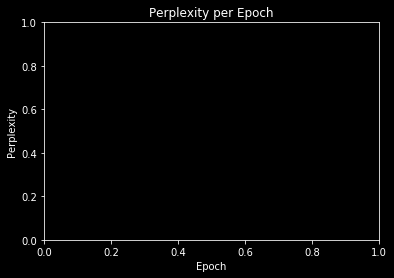

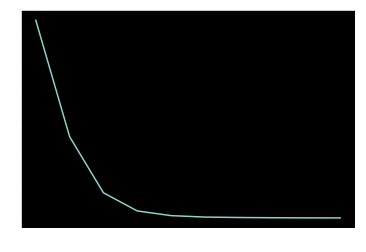

In [43]:

def plotPerplexity(perplexities):
    """plot perplexities"""
    plt.title("Perplexity per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Perplexity")
    plt.figure(facecolor="white")
    plt.plot(perplexities)

plotPerplexity(devPerplexities)

You can see that the model managed to correctly 'translate' the two examples in the end.

Moreover, the perplexity of the development data nicely went down towards 1.

# A Real World Example

Now we consider a real-world example using the IWSLT German-English Translation task.
This task is much smaller than usual, but it illustrates the whole system.

The cell below installs torch text and spacy. This might take a while.

In [ ]:
#!pip install git+git://github.com/pytorch/text spacy
#!python -m spacy download en
#!python -m spacy download de

## Data Loading

We will load the dataset using torchtext and spacy for tokenization.

This cell might take a while to run the first time, as it will download and tokenize the IWSLT data.

For speed we only include short sentences, and we include a word in the vocabulary only if it occurs at least 5 times. In this case we also lowercase the data.

If you have **issues** with torch text in the cell below (e.g. an `ascii` error), try running `export LC_ALL="en_US.UTF-8"` before you start `jupyter notebook`.

In [ ]:
# For data loading.
from torchtext import data, datasets

if True:
    import spacy
    spacy_de = spacy.load('de')
    spacy_en = spacy.load('en')

    def tokenizeDE(text):
        return [tok.text for tok in spacy_de.tokenizer(text)]

    def tokenizeEN(text):
        return [tok.text for tok in spacy_en.tokenizer(text)]

    UNK_TOKEN = "<unk>"
    PAD_TOKEN = "<pad>"
    SOS_TOKEN = "<s>"
    EOS_TOKEN = "</s>"
    LOWER = True

    # we include lengths to provide to the RNNs
    SRC = data.Field(tokenize=tokenizeDE,
                     batch_first=True, lower=LOWER, include_lengths=True,
                     unk_token=UNK_TOKEN, pad_token=PAD_TOKEN, init_token=None, eos_token=EOS_TOKEN)
    TRG = data.Field(tokenize=tokenizeEN,
                     batch_first=True, lower=LOWER, include_lengths=True,
                     unk_token=UNK_TOKEN, pad_token=PAD_TOKEN, init_token=SOS_TOKEN, eos_token=EOS_TOKEN)

    MAX_LEN = 25  # NOTE: we filter out a lot of sentences for speed
    trainData, validData, testData = datasets.IWSLT.splits(
        exts=('.de', '.en'), fields=(SRC, TRG),
        filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and
            len(vars(x)['trg']) <= MAX_LEN)
    MIN_FREQ = 5  # NOTE: we limit the vocabulary to frequent words for speed
    SRC.build_vocab(trainData.src, min_freq=MIN_FREQ)
    TRG.build_vocab(trainData.trg, min_freq=MIN_FREQ)

    PAD_INDEX = TRG.vocab.stoi[PAD_TOKEN]

### Let's look at the data

It never hurts to look at your data and some statistics.

In [ ]:
def printDataInfo(trainData, validationData, testData, sourceField, targetField):
    """ This prints some useful stuff about our data sets. """

    print("Data set sizes (number of sentence pairs):")
    print('train', len(trainData))
    print('valid', len(validationData))
    print('test', len(testData), "\n")

    print("First training example:")
    print("src:", " ".join(vars(trainData[0])['src']))
    print("trg:", " ".join(vars(trainData[0])['trg']), "\n")

    print("Most common words (src):")
    print("\n".join(["%10s %10d" % x for x in sourceField.vocab.freqs.most_common(10)]), "\n")
    print("Most common words (trg):")
    print("\n".join(["%10s %10d" % x for x in targetField.vocab.freqs.most_common(10)]), "\n")

    print("First 10 words (src):")
    print("\n".join(
        '%02d %s' % (i, t) for i, t in enumerate(sourceField.vocab.itos[:10])), "\n")
    print("First 10 words (trg):")
    print("\n".join(
        '%02d %s' % (i, t) for i, t in enumerate(targetField.vocab.itos[:10])), "\n")

    print("Number of German words (types):", len(sourceField.vocab))
    print("Number of English words (types):", len(targetField.vocab), "\n")


printDataInfo(trainData, validData, testData, SRC, TRG)

## Iterators
Batching matters a ton for speed. We will use torch text's BucketIterator here to get batches containing sentences of (almost) the same length.

#### Note on sorting batches for RNNs in PyTorch

For effiency reasons, PyTorch RNNs require that batches have been sorted by length, with the longest sentence in the batch first. For training, we simply sort each batch.
For validation, we would run into trouble if we want to compare our translations with some external file that was not sorted. Therefore we simply set the validation batch size to 1, so that we can keep it in the original order.

In [ ]:
trainIter = data.BucketIterator(trainData, batch_size=64, train=True,
                                sort_within_batch=True,
                                sort_key=lambda x: (len(x.src), len(x.trg)), repeat=False,
                                device=DEVICE)
validIter = data.Iterator(validData, batch_size=1, train=False, sort=False, repeat=False,
                          device=DEVICE)


def rebatch(padIndex, batch):
    """Wrap torchtext batch into our own Batch class for pre-processing"""
    return Batch(batch.src, batch.trg, padIndex)

## Training the System

Now we train the model.

On a Titan X GPU, this runs at ~18,000 tokens per second with a batch size of 64.

In [ ]:
def train(model, numEpochs=10, learningRate=0.0003, printEvery=100):
    """Train a model on IWSLT"""

    #if USE_CUDA:
    #    model.cuda()

    # optionally add label smoothing; see the Annotated Transformer
    criterion = nn.NLLLoss(reduction="sum", ignore_index=PAD_INDEX)
    optim = torch.optim.Adam(model.parameters(), lr=learningRate)

    devPerplexities = []

    for epoch in range(numEpochs):

        print("Epoch", epoch)
        model.train()
        trainPerplexity = runEpoch((rebatch(PAD_INDEX, b) for b in trainIter),
                                    model,
                                    SimpleLossCompute(model.generator, criterion, optim),
                                    printEvery=printEvery)

        model.eval()
        with torch.no_grad():
            printExamples((rebatch(PAD_INDEX, x) for x in validIter),
                          model, n=3, srcVocab=SRC.vocab, trgVocab=TRG.vocab)

            dev_perplexity = runEpoch((rebatch(PAD_INDEX, b) for b in validIter),
                                      model,
                                      SimpleLossCompute(model.generator, criterion, None))
            print("Validation perplexity: %f" % dev_perplexity)
            devPerplexities.append(dev_perplexity)

    return devPerplexities


In [ ]:
model = makeModel(len(SRC.vocab), len(TRG.vocab),
                  embeddingSize=256, hiddenSize=256,
                  numLayers=1, dropout=0.2)
devPerplexities = train(model, printEvery=100)

In [ ]:
plotPerplexity(devPerplexities)

## Prediction and Evaluation

Once trained we can use the model to produce a set of translations.

If we translate the whole validation set, we can use [SacreBLEU](https://github.com/mjpost/sacreBLEU) to get a [BLEU score](https://en.wikipedia.org/wiki/BLEU), which is the most common way to evaluate translations.

#### Important sidenote
Typically you would use SacreBLEU from the **command line** using the output file and original (possibly tokenized) development reference file. This will give you a nice version string that shows how the BLEU score was calculated; for example, if it was lowercased, if it was tokenized (and how), and what smoothing was used. If you want to learn more about how BLEU scores are (and should be) reported, check out [this paper](https://arxiv.org/abs/1804.08771).

However, right now our pre-processed data is only in memory, so we'll calculate the BLEU score right from this notebook for demonstration purposes.

We'll first test the raw BLEU function:

In [ ]:
import sacrebleu

In [ ]:
# this should result in a perfect BLEU of 100%
hypotheses = ["this is a test"]
references = ["this is a test"]
bleu = sacrebleu.raw_corpus_bleu(hypotheses, [references], .01).score
print(bleu)

In [ ]:
# here the BLEU score will be lower, because some n-grams won't match
hypotheses = ["this is a test"]
references = ["this is a fest"]
bleu = sacrebleu.raw_corpus_bleu(hypotheses, [references], .01).score
print(bleu)

Since we did some filtering for speed, our validation set contains 690 sentences.
The references are the tokenized versions, but they should not contain out-of-vocabulary UNKs that our network might have seen. So we'll take the references straight out of the `valid_data` object:

In [ ]:
len(validData)

In [ ]:
references = [" ".join(example.trg) for example in validData]
print(len(references))
print(references[0])

In [ ]:
references[-2]

**Now we translate the validation set!**

This might take a little bit of time.

Note that `greedy_decode` will cut-off the sentence when it encounters the end-of-sequence symbol, if we provide it the index of that symbol.

In [ ]:
hypotheses = []
alphas = []  # save the last attention scores
for batch in validIter:
  batch = rebatch(PAD_INDEX, batch)
  pred, attention = greedyDecode(
    model, batch.source, batch.sourceMask, batch.sourceLengths, maxLen=25,
    sosIndex=TRG.vocab.stoi[SOS_TOKEN],
    eosIndex=TRG.vocab.stoi[EOS_TOKEN])
  hypotheses.append(pred)
  alphas.append(attention)

In [ ]:
# we will still need to convert the indices to actual words!
hypotheses[0]

In [ ]:
hypotheses = [lookupWords(x, TRG.vocab) for x in hypotheses]
hypotheses[0]

In [ ]:
# finally, the SacreBLEU raw scorer requires string input, so we convert the lists to strings
hypotheses = [" ".join(x) for x in hypotheses]
print(len(hypotheses))
print(hypotheses[0])

In [ ]:
# now we can compute the BLEU score!
bleu = sacrebleu.raw_corpus_bleu(hypotheses, [references], .01).score
print(bleu)

## Attention Visualization

We can also visualize the attention scores of the decoder.

In [ ]:
def plotHeatmap(src, trg, scores):

    fig, ax = plt.subplots()
    heatmap = ax.pcolor(scores, cmap='viridis')

    ax.set_xticklabels(trg, minor=False, rotation='vertical')
    ax.set_yticklabels(src, minor=False)

    # put the major ticks at the middle of each cell
    # and the x-ticks on top
    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(scores.shape[1]) + 0.5, minor=False)
    ax.set_yticks(np.arange(scores.shape[0]) + 0.5, minor=False)
    ax.invert_yaxis()

    plt.colorbar(heatmap)
    plt.show()

In [ ]:
# This plots a chosen sentence, for which we saved the attention scores above.
idx = 5
src = validData[idx].src + ["</s>"]
trg = validData[idx].trg + ["</s>"]
pred = hypotheses[idx].split() + ["</s>"]
predAtt = alphas[idx][0].T[:, :len(pred)]
print("src", src)
print("ref", trg)
print("pred", pred)
plotHeatmap(src, pred, predAtt)

# Congratulations! You've finished this notebook.

What didn't we cover?

- Subwords / Byte Pair Encoding [[paper]](https://arxiv.org/abs/1508.07909) [[github]](https://github.com/rsennrich/subword-nmt) let you deal with unknown words.
- You can implement a [multiplicative/bilinear attention mechanism](https://arxiv.org/abs/1508.04025) instead of the additive one used here.
- We used greedy decoding here to get translations, but you can get better results with beam search.
- The original model only uses a single dropout layer (in the decoder), but you can experiment with adding more dropout layers, for example on the word embeddings and the source word representations.
- You can experiment with multiple encoder/decoder layers.- Experiment with a benchmarked and improved codebase: [Joey NMT](https://github.com/joeynmt/joeynmt)

If this was useful to your research, please consider citing:

> Joost Bastings. 2018. The Annotated Encoder-Decoder with Attention. https://bastings.github.io/annotated_encoder_decoder/

Or use the following `Bibtex`:
```
@misc{bastings2018annotated,
  title={The Annotated Encoder-Decoder with Attention},
  author={Bastings, Joost},
  journal={https://bastings.github.io/annotated\_encoder\_decoder/},
  year={2018}
}```